/var/folders/1f/9sw91vb56l9dpgy8zb1m887w0000gn/T/ipykernel_24881/3392914882.py:34: UserWarning: Glyph 12456 (\N{KATAKANA LETTER E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/1f/9sw91vb56l9dpgy8zb1m887w0000gn/T/ipykernel_24881/3392914882.py:34: UserWarning: Glyph 12524 (\N{KATAKANA LETTER RE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/1f/9sw91vb56l9dpgy8zb1m887w0000gn/T/ipykernel_24881/3392914882.py:34: UserWarning: Glyph 12460 (\N{KATAKANA LETTER GA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/1f/9sw91vb56l9dpgy8zb1m887w0000gn/T/ipykernel_24881/3392914882.py:34: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/1f/9sw91vb56l9dpgy8zb1m887w0000gn/T/ipykernel_24881/3392914882.py:34: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/envs/scraping/lib/python3.12/site-packages/IPyt

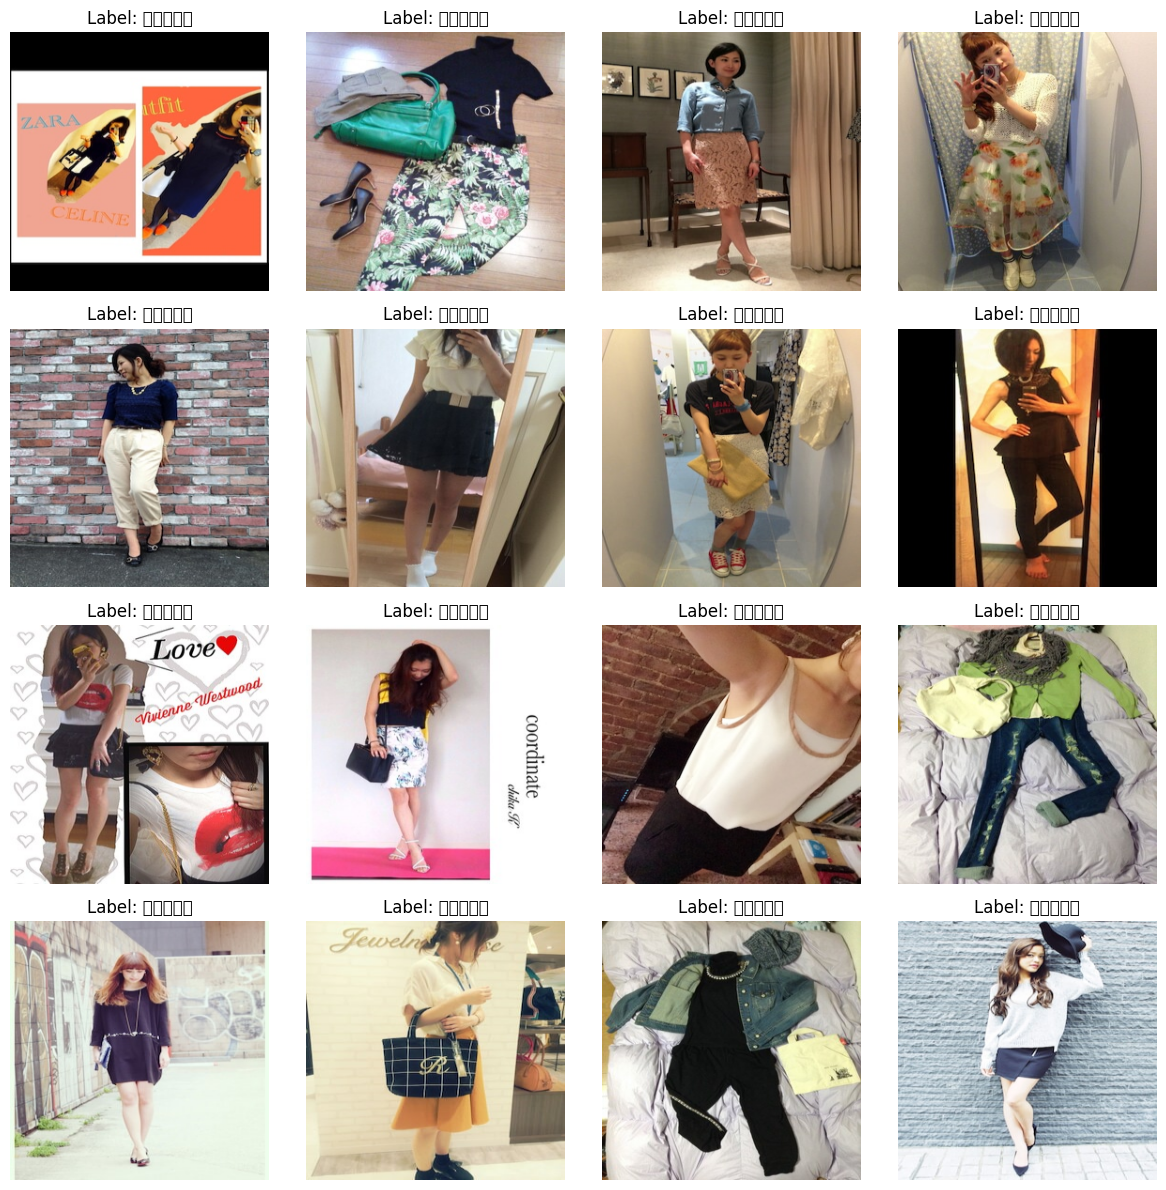

Loaded 4733 images


In [4]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image, UnidentifiedImageError
import os
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# -- 各設定値 --
img_height = 276  # 画像の幅
img_width = 276   # 画像の高さ
batch_size = 10
latent_size = 1  # 潜在空間の次元を1に設定
image_size = 276  # デコーダーで使う画像サイズ
intarval = 2
num_epochs = 10
name_model = "VAE_EleganceTrad"

# 可視化関数
def visualize_dataset(dataset, num_images=16):
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.flatten()

    for i in range(num_images):
        img, label = dataset[i]
        img = img.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f'Label: {dataset.categories[label]}')

    plt.tight_layout()
    plt.show()

# 画像ファイルが有効かどうかをチェックする関数
def is_valid_image_file(filepath):
    try:
        with Image.open(filepath) as img:
            img.verify()  # 画像として有効か確認
        return True
    except (UnidentifiedImageError, OSError):
        return False

# -- データセットのディレクトリとクラス名の指定 --
base_dir = r'/Volumes/public/Document/Python/VAE/data/data'
categories = ['エレガンス', 'トラッド']

# データセットクラスの定義
class CustomImageDataset(Dataset):
    def __init__(self, base_dir, categories, transform=None):
        self.base_dir = base_dir
        self.categories = categories
        self.transform = transform
        self.image_paths = []
        self.labels = []
        for idx, category in enumerate(categories):
            folder_path = os.path.join(base_dir, category)
            for filename in os.listdir(folder_path):
                file_path = os.path.join(folder_path, filename)
                if is_valid_image_file(file_path):  # 有効な画像ファイルのみ追加
                    self.image_paths.append(file_path)
                    self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

# 画像データの前処理
transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
])

# データセットとデータローダーの作成
dataset = CustomImageDataset(base_dir=base_dir, categories=categories, transform=transform)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# データセットの可視化
visualize_dataset(dataset, num_images=16)
print(f"Loaded {len(dataset)} images")


In [5]:
# モデルの定義
class Encoder(nn.Module):
    def __init__(self, latent_size, image_size):
        super(Encoder, self).__init__()
        self.H = int(image_size / 4)  # ダウンサンプリングされるサイズ
        self.W = int(image_size / 4)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.linear1 = nn.Linear(128 * self.H * self.W, 64)
        self.linear2 = nn.Linear(64, latent_size)  # 潜在変数の次元を1に変更
        self.linear3 = nn.Linear(64, latent_size)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.shape[0], -1)  # Flatten
        x = F.relu(self.linear1(x))
        z_mean = self.linear2(x)
        z_log_var = self.linear3(x)
        return z_mean, z_log_var

    def sampling(self, z_mean, z_log_var):
        epsilon = torch.randn(z_mean.shape, device=z_mean.device)
        return z_mean + epsilon * torch.exp(0.5 * z_log_var)

class Decoder(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.H = int(image_size / 4)
        self.W = int(image_size / 4)
        self.to_shape = (128, self.H, self.W)
        self.linear = nn.Linear(latent_size, 128 * self.H * self.W)  # 潜在サイズを1に変更
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = F.relu(self.linear(x))
        x = x.view(-1, *self.to_shape)  # Reshape to (batch, C, H, W)
        x = F.relu(self.deconv1(x))
        x = torch.sigmoid(self.deconv2(x))
        return x

class VAE(nn.Module):
    def __init__(self, latent_size, image_size):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_size, image_size)
        self.decoder = Decoder(image_size)

    def forward(self, x, C=1.0, k=1):
        z_mean, z_log_var = self.encoder(x)

        rec_loss = 0
        for _ in range(k):
            z = self.encoder.sampling(z_mean, z_log_var)
            y = self.decoder(z)
            rec_loss += F.binary_cross_entropy(torch.flatten(y, start_dim=1), torch.flatten(x, start_dim=1)) / k

        kl_loss = C * (z_mean ** 2 + torch.exp(z_log_var) - z_log_var - 1) * 0.5
        kl_loss = torch.sum(kl_loss) / len(x)
        return rec_loss + kl_loss

Epoch [2/10], Loss: 0.7330


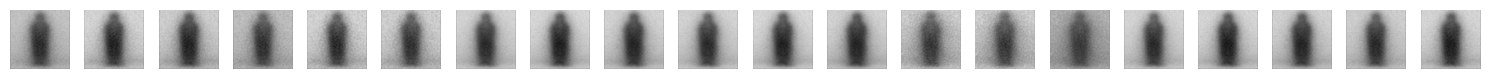

Epoch [4/10], Loss: 0.6512


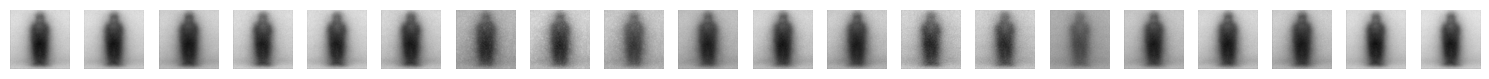

Epoch [6/10], Loss: 0.6476


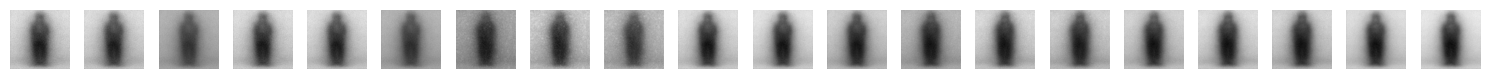

Epoch [8/10], Loss: 0.6482


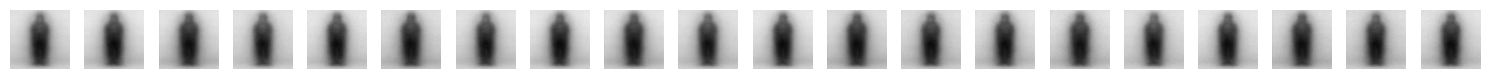

Epoch [10/10], Loss: 0.6495


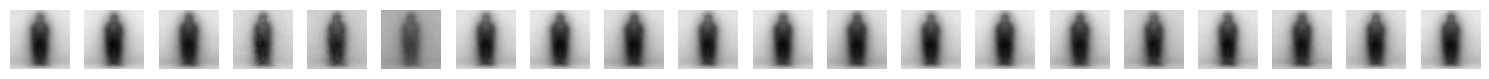

In [ ]:
# 学習設定
device = torch.device("cpu")
model = VAE(latent_size=latent_size, image_size=image_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

import matplotlib.pyplot as plt
import numpy as np
import torch


# ランダムな潜在空間画像の生成関数
def generate_latent_space_images(model, n_image=20, img_height=276, img_width=276, latent_size=1, device='cpu'):  
    with torch.no_grad():  # 勾配計算を無効化
        z = torch.randn(n_image, latent_size, device=device)  # 1次元の潜在空間からサンプルを生成
        images = model.decoder(z)  # デコーダーを通して画像を生成
        images = images.view(-1, img_height, img_width)  # 画像サイズにリシェイプ
        images = images.detach().cpu().numpy()  # NumPy配列に変換
    # データの可視化
    plt.figure(figsize=(15, 6))  # 図のサイズを設定
    for i in range(n_image):  # 0から19までのインデックスを使う
        plt.subplot(1, n_image, i + 1)  #  1行n列に設定
        plt.imshow(images[i], cmap='binary_r')  # 画像を表示
        plt.axis('off')  # 軸を非表示にする
    plt.tight_layout()  # レイアウトを整える
    plt.show()

# 学習ループ
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        loss = model(data)
        loss.backward()
        total_loss += loss.item()
        optimizer.step()

    if (epoch + 1) % intarval == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}')
        # generate_latent_space_images(model)
        generate_latent_space_images(model)

In [7]:
# モデルの保存
torch.save(model.state_dict(), '/Volumes/public/Document/Python/VAE/data3/models/'+name_model+'.pth')  # 'vae_model.pth' は保存するファイル名
print("モデルが保存されました。")

モデルが保存されました。


潜在変数 z: tensor([[0.0638]])
torch.Size([3, 276, 276])


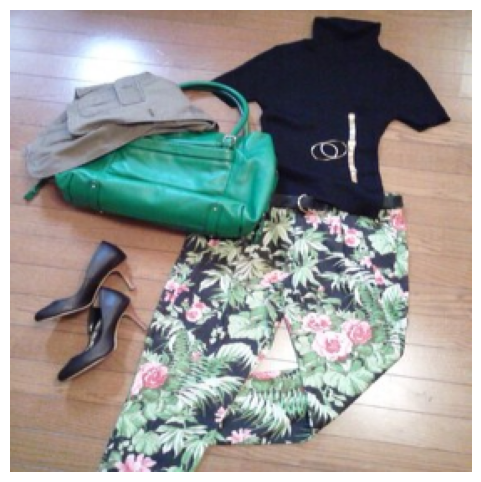

In [8]:
import torch

# モデルを評価モードに設定
model.eval()

num = 1
# データセットから画像を取得
img, _ = dataset[num]

# 画像をバッチサイズ1のテンソルに変換
img = img.unsqueeze(0)  # (C, H, W) -> (1, C, H, W)

# 画像をモデルに入力し、潜在変数を取得
with torch.no_grad():  # 勾配計算を無効にする
    z_mean, z_log_var = model.encoder(img)  # 'encode' メソッドを使用
    std = torch.exp(0.5 * z_log_var)  # 標準偏差を計算
    epsilon = torch.randn_like(std)  # 標準正規分布からのランダムな値を生成
    z = z_mean + epsilon * std  # 潜在変数を計算

# 潜在変数の値を表示
print("潜在変数 z:", z)

# データセットから画像を取得
img_show, _ = dataset[num]
print(img_show.shape)

# (C, H, W) -> (H, W, C) に変換
img_show = img_show.permute(1, 2, 0).numpy()

# 1枚だけ表示する
plt.figure(figsize=(6, 6))  # 図のサイズを設定
plt.imshow(img_show)
plt.axis('off')  # 軸を表示しない
plt.show()